In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d sakshimote/plant-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/sakshimote/plant-disease-dataset
License(s): apache-2.0
100%|██████████████████████████████████████▉| 7.26G/7.27G [00:52<00:00, 189MB/s]
100%|███████████████████████████████████████| 7.27G/7.27G [00:52<00:00, 148MB/s]


In [3]:
!apt-get install pigz -y
!unzip -q /kaggle/working/plant-disease-dataset.zip -d /kaggle/working/ | pigz -d -p 4


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  pigz
0 upgraded, 1 newly installed, 0 to remove and 129 not upgraded.
Need to get 63.6 kB of archives.
After this operation, 162 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 pigz amd64 2.6-1 [63.6 kB]
Fetched 63.6 kB in 0s (421 kB/s)
Selecting previously unselected package pigz.
(Reading database ... 127400 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.6-1_amd64.deb ...
Unpacking pigz (2.6-1) ...
Setting up pigz (2.6-1) ...
Processing triggers for man-db (2.10.2-1) ...
pigz: skipping: <stdin> empty


In [5]:
import os
import random
import shutil

# --- Configuration ---
source_folder = "/kaggle/working/resized_images"  # Your original dataset path
destination_folder = "balanced_dataset"           #  New folder name where balanced dataset will be saved
images_per_class = 1000                            #  How many images per class you want

# --- Balancing Script ---
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        
        # If images are less than required, copy all
        if len(images) <= images_per_class:
            selected_images = images
        else:
            selected_images = random.sample(images, images_per_class)
        
        # Create class folder inside 'balanced_dataset/'
        dest_class_path = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_path, exist_ok=True)
        
        # Copy selected images
        for img_name in selected_images:
            src_img_path = os.path.join(class_path, img_name)
            dest_img_path = os.path.join(dest_class_path, img_name)
            shutil.copy2(src_img_path, dest_img_path)

print(" Balanced dataset is saved inside 'balanced_dataset/' folder!")


 Balanced dataset is saved inside 'balanced_dataset/' folder!


In [6]:
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import json

# 1. Define paths and collect image data
image_dir = "/kaggle/working/balanced_dataset"   #  balanced dataset path
image_paths = glob(os.path.join(image_dir, "*", "*.*"))
print("Total images found:", len(image_paths))

data = {"image_path": [], "label": []}
for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    data["image_path"].append(path)
    data["label"].append(label)

df = pd.DataFrame(data)
print("Sample rows:\n", df.head())

# 2. Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

# 3. Save CSVs
os.makedirs("/kaggle/working/dataset_splits", exist_ok=True)
train_df.to_csv("/kaggle/working/dataset_splits/train.csv", index=False)
val_df.to_csv("/kaggle/working/dataset_splits/val.csv", index=False)
test_df.to_csv("/kaggle/working/dataset_splits/test.csv", index=False)

print("Data split done and saved as CSVs.")


Total images found: 51590
Sample rows:
                                           image_path               label
0  /kaggle/working/balanced_dataset/sugarcane__Re...  sugarcane__Red Rot
1  /kaggle/working/balanced_dataset/sugarcane__Re...  sugarcane__Red Rot
2  /kaggle/working/balanced_dataset/sugarcane__Re...  sugarcane__Red Rot
3  /kaggle/working/balanced_dataset/sugarcane__Re...  sugarcane__Red Rot
4  /kaggle/working/balanced_dataset/sugarcane__Re...  sugarcane__Red Rot
Data split done and saved as CSVs.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define paths and settings
dataset_dir = "/kaggle/working/balanced_dataset"
train_csv = "/kaggle/working/dataset_splits/train.csv"
val_csv = "/kaggle/working/dataset_splits/val.csv"
test_csv = "/kaggle/working/dataset_splits/test.csv"

img_size = (224, 224)
batch_size = 32
SEED = 42

# 2. Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# 3. Function to load datasets
def load_data(csv_path, datagen, shuffle=True):
    df = pd.read_csv(csv_path)
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col="image_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        seed=SEED,
        shuffle=shuffle,
        num_workers=2,
        use_multiprocessing=True
    )

# 4. Load train, val, test sets
train_data = load_data(train_csv, train_datagen, shuffle=True)
val_data = load_data(val_csv, val_test_datagen, shuffle=False)
test_data = load_data(test_csv, val_test_datagen, shuffle=False)

# 5. Save class indices
class_indices = train_data.class_indices
print("Class Indices Mapping:", class_indices)
with open("/kaggle/working/class_indices.json", "w") as f:
    json.dump(class_indices, f)

num_classes = len(class_indices)


Found 36113 validated image filenames belonging to 76 classes.
Found 7738 validated image filenames belonging to 76 classes.
Found 7739 validated image filenames belonging to 76 classes.
Class Indices Mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Guava_anthracnose': 15, 'Guava_healthy': 16, 'Guava_insect_bite': 17, 'Guava_multiple': 18, 'Guava_scorch': 19, 'Guava_yld': 20, 'Lemon_Anthracnose': 21, 'Lemon_Bacterial Blight': 22, 'Lemon_Citrus Canker': 23, 'Lemon_Curl Virus': 24, 'Lemon_Deficiency Leaf': 25, 'Lemon_Dry L

In [15]:
# Imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import json
import os

# Mixed precision + XLA
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

# Paths
train_csv = "/kaggle/working/dataset_splits/train.csv"
val_csv = "/kaggle/working/dataset_splits/val.csv"
test_csv = "/kaggle/working/dataset_splits/test.csv"
class_json = "/kaggle/working/class_indices.json"

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 20  # more epochs for fine-tuning

# Load class indices
with open(class_json, 'r') as f:
    class_indices = json.load(f)
num_classes = len(class_indices)

# Image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data function
def load_data(csv_path, datagen, shuffle=True):
    df = pd.read_csv(csv_path)
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col="image_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=shuffle
    )

# Load datasets
train_data = load_data(train_csv, train_datagen)
val_data = load_data(val_csv, val_datagen)
test_data = load_data(test_csv, val_datagen, shuffle=False)

# Load Pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # First freeze base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Compute class weights
labels = train_data.classes
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight = {i: weights[i] for i in range(len(weights))}

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Train head (only new layers)
print("Starting training head...")
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

# Unfreeze some layers and fine-tune
print("Fine-tuning...")
base_model.trainable = True

# Optional: freeze first few layers if you want
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with low learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_epochs = 15
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

# Save model
model.save("/kaggle/working/cropshield_ai.h5")
print(" Model saved successfully!")


Found 36113 validated image filenames belonging to 76 classes.
Found 7738 validated image filenames belonging to 76 classes.
Found 7739 validated image filenames belonging to 76 classes.
Starting training head...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 422s 365ms/step - accuracy: 0.5702 - loss: 1.7639 - val_accuracy: 0.8766 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 405s 356ms/step - accuracy: 0.8200 - loss: 0.5735 - val_accuracy: 0.8979 - val_loss: 0.2993 - learning_rate: 0.0010
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 403s 354ms/step - accuracy: 0.8439 - loss: 0.4787 - val_accuracy: 0.9000 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 403s 355ms/step - accuracy: 0.8514 - loss: 0.4458 - val_accuracy: 0.8995 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 408s 359ms/step - accuracy: 0.8591 - loss: 0.4258 - val_accuracy: 0.8975 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 403s 355ms/step - accuracy: 0.8688 - loss: 0.3808 - val_accuracy: 0.9101 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 410s 361ms/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


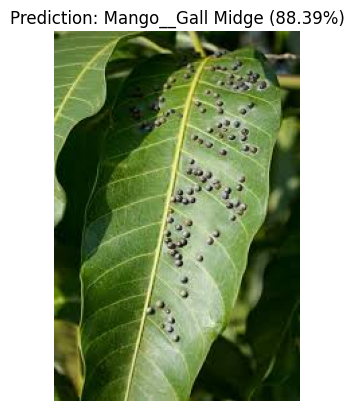

Predicted Label: Mango__Gall Midge
Confidence: 88.39%


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import custom_object_scope

# Create a Dummy Cast Layer
class DummyCast(Layer):
    def __init__(self, dtype=None, **kwargs):
        super(DummyCast, self).__init__(**kwargs)
        self.dtype_ = dtype

    def call(self, inputs):
        return inputs

# Load model with custom object
custom_objects = {'Cast': DummyCast}

with custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("/kaggle/working/cropshield_ai.h5", compile=False)

# Prediction code here
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

# Load class indices
with open("/kaggle/working/class_indices.json", "r") as f:
    class_indices = json.load(f)
index_to_class = {v: k for k, v in class_indices.items()}

# Predict single image
def predict_single_image(image_path):
    img_size = (224, 224)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Couldn't read image at {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_class = index_to_class[pred_idx]
    confidence = preds[0][pred_idx] * 100

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return pred_class, confidence

# Example usage
image_path = "/kaggle/input/images/mango.jpg"  # change it
predicted_label, confidence = predict_single_image(image_path)

print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")
